In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../src/python')

from balance_split_data import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, \
get_feature_importance, get_feature_importance10

### Load data

In [3]:
df = pd.read_json(r"../../data/processed/pre-processed_2023_03_20.json")

### Balance data and split to train and test set

In [5]:
label_name = "phase2"

In [6]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [7]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [8]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2),(1,1),(1,3), (2,2),(2,3), (2,4), (3,3), (3,4)], #(1,2),(1,1),(1,3),
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [9]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1')

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
done in 2814.584s
Best cross-validation score:  0.9348109517601043
Best parameters set:
	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (3, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


##### Model fitting and evaluation

In [10]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=3)

fitting the best model
Accuracy: 0.9299363057324841

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93        79
           1       0.89      0.97      0.93        78

    accuracy                           0.93       157
   macro avg       0.93      0.93      0.93       157
weighted avg       0.93      0.93      0.93       157


CR: (0.9331699346405229, 0.9302174618630314, 0.9298338276520538, None)

Confusion matrix:
 [[70  9]
 [ 2 76]] 

_______________________


 Accuracy: 92.99 
 Precision: 0.894 
 Recall: 0.974 
 F1: 0.933


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [11]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../../output/tables/features_svm_cv_full.xlsx', index=True)
df_features_cv.head()

,feature,importance
1565,europese commissie brussel,-0.651748
898,confidential information disclosed,0.620311
2027,information disclosed enclosed,0.620311
1321,disclosed enclosed square,0.620311
1481,enclosed square bracket,0.618612


In [12]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.9755073477956613

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1409
           1       0.35      0.90      0.51        20

    accuracy                           0.98      1429
   macro avg       0.68      0.94      0.75      1429
weighted avg       0.99      0.98      0.98      1429


CR: (0.6757448988303595, 0.9382895670688431, 0.7472419735492251, None)

Confusion matrix:
 [[1376   33]
 [   2   18]] 

_______________________


 Accuracy: 97.55 
 Precision: 0.353 
 Recall: 0.900 
 F1: 0.507


### Model training (with 10-fold CV) using best parameters from GridSearch

In [175]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (3, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


In [9]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (3,3), binary = True, max_df = 0.025, norm = 'l2', use_idf = True))
c = 5
# solver = 'liblinear'
model=LinearSVC(C=c)

In [10]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.8280254777070064

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83        79
           1       0.85      0.79      0.82        78

    accuracy                           0.83       157
   macro avg       0.83      0.83      0.83       157
weighted avg       0.83      0.83      0.83       157


CR: (0.8294194390084801, 0.8278156442713405, 0.8277739406004957, None)

Confusion matrix:
 [[68 11]
 [16 62]] 

_______________________


 Accuracy: 82.80 
 Precision: 0.849 
 Recall: 0.795 
 F1: 0.821


In [11]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.8649405178446467

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93      1409
           1       0.08      0.85      0.15        20

    accuracy                           0.86      1429
   macro avg       0.54      0.86      0.54      1429
weighted avg       0.98      0.86      0.92      1429


CR: (0.5398353060240202, 0.8575762952448545, 0.5382117986661912, None)

Confusion matrix:
 [[1219  190]
 [   3   17]] 

_______________________


 Accuracy: 86.49 
 Precision: 0.082 
 Recall: 0.850 
 F1: 0.150


In [12]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.825

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       0.81      0.85      0.83        20

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40


CR: (0.8258145363408521, 0.825, 0.8248905565978737, None)

Confusion matrix:
 [[16  4]
 [ 3 17]] 

_______________________


 Accuracy: 82.50 
 Precision: 0.810 
 Recall: 0.850 
 F1: 0.829


### Feature importance

In [13]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
432,business eur million,1.101389,1.101389
2900,network quality coverage,0.787179,0.787179
2778,mvno wholesale access,0.787179,0.787179
1585,exceeding eur million,0.745485,0.745485
3979,product market need,0.739872,0.739872
742,company jointly controlled,-0.738000,0.738000
1485,eur billion community,-0.732496,0.732496
1586,exceeds cid million,-0.722177,0.722177
4490,standard european standard,-0.703076,0.703076
3410,party submit respective,-0.568606,0.568606


In [234]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [14]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

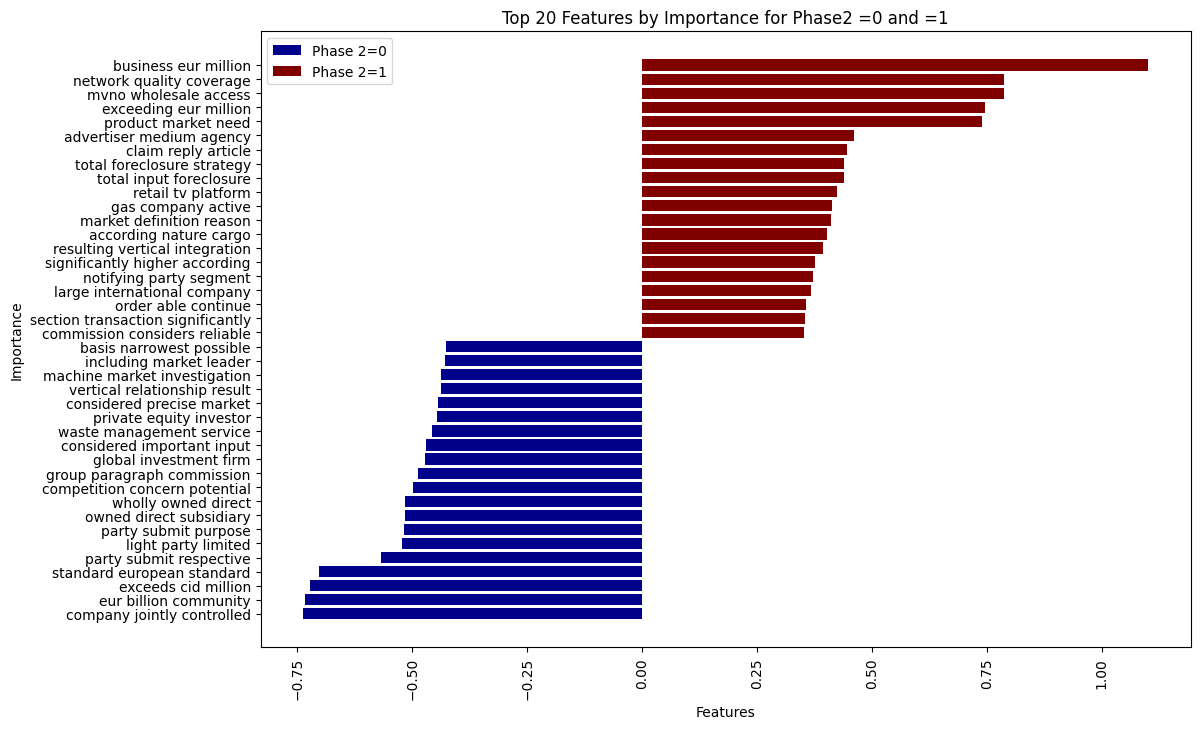

In [15]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Features by Importance for Phase2 =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [36]:
df_features_train.to_excel('../../../../output/tables/features_svm_train_full_baseline.xlsx', index=True)